# LIFEsim Tutorial @ LIFE Science Team Meeting, Berlin (25. - 27. September 2023)
The following is a tutorial that should illustrate the use cases of the current version of LIFEsim and how to interpret its output.

For questions regarding LIFEsim please contact huberph@phys.ethz.ch.

Backup links in case the file downloads don't work:


*   [Example 1A](https://github.com/pahuber/LIFEsim_Tutorial/blob/main/1a_example_spectrum.txt)
*   [Example 1B Earth](https://github.com/pahuber/LIFEsim_Tutorial/blob/main/psg_rad.txt)
*   [Example 1B Earth O3x1000](https://github.com/pahuber/LIFEsim_Tutorial/blob/main/psg_rad_o3_10x.txt)
*   [Example 2A/B Exoplanet Population Catalog](https://github.com/pahuber/LIFEsim_Tutorial/blob/main/2a_example_catalog.txt)



#0) Prerequisites
Set Up Environment and Load Data. This step is required for each of the examples.

In [1]:
#@title Install LIFEsim
!pip install lifesim>='0.2.32'
!pip install git+https://github.com/fdannert/SpectRes.git

  Cloning https://github.com/fdannert/SpectRes.git to /tmp/pip-req-build-yytujgvx
  Running command git clone --filter=blob:none --quiet https://github.com/fdannert/SpectRes.git /tmp/pip-req-build-yytujgvx
  Resolved https://github.com/fdannert/SpectRes.git to commit 7a8c83025096c8907de30db633cca30c6f4b97ce
  Preparing metadata (setup.py) ... done
  Created wheel for spectres: filename=spectres-2.1.1-py2.py3-none-any.whl size=16105 sha256=bbc5e758052f11cc033dab10ed8824b755981f2af57d1e4699e50f2f36163cb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-6roubs41/wheels/41/7d/fb/b63f059ae5cb8eb082f0c0c34697f431230701eb0d59182435
Successfully built spectres


In [2]:
import lifesim

#1) Use Case: Noisy Spectrum Generation
LIFEsim can be used to simulate the spectral noise we can expect for an observation with LIFE.

## 1.A) Demo: How to use LIFEsim
How can we simulate the spectral noise we would get from a LIFE observation? In this example we take a dummy spectrum that is already in units of ph s-1 m-2 um-1, plug it into LIFEsim and simulate the noise we would get by spectral channel with LIFE.

Note: With the exception of step 0), this example is self-contained.

In [ ]:
#@title 1.A.1) Download and Save Example Spectrum
import requests
import numpy as np


url = r'https://raw.githubusercontent.com/pahuber/LIFEsim_Tutorial/main/1a_example_spectrum.txt'
response = requests.get(url)

with open('1a_example_spectrum.txt', 'w') as text_file:
  text_file.write(response.text)


In [ ]:
#@title 1.A.2) Set Your Simulation Variables
scenario = 'baseline' # Options: 'basline', 'pessimistic', 'optimistic'
spectral_resolution = 50  # Resolving power
minimum_wavelength = 4 # Minimum wavelength of the spectrometer in micron
maximum_wavelength = 18 # Maximum wavelength of the spectrometer in micron
integration_time = 55*60*60  # Overall integration time in s

planet_radius = 1  # Planet effective radius in Earth radii
planet_angular_separation = 0.1  # Planet angular separation from host star in arcsec
star_distance = 10  # Distance to the target system in pc
star_temperature = 5778  # Star effective temperature in K
star_radius = 1  # Star effective radius in Solar radii
exozodi_level = 3  # Exozodi level in zodis


# For reference, here's a list of all options that can be manually set.
# We recommend that you only set these manually if you know what you are doing.

# Array-specific:
# 'diameter': 0.,
# 'quantum_eff': 0.,
# 'throughput': 0.,
# 'wl_min': 0.,
# 'wl_max': 0.,
# 'spec_res': 0,
# 'baseline': 0.,
# 'bl_min': 0.,
# 'bl_max': 0.,
# 'ratio': 0.,
# 't_slew': 0.,
# 't_efficiency': 0.}

# Other:
# 'image_size': 0,
# 'wl_optimal': 0.,
# 'n_plugins': 0,
# 'output_path': None,
# 'output_filename': None

# Model-specific
# 'localzodi': '',
# 'habitable': ''

# Optimization-specific
# 'N_pf': 0.,
# 'snr_target': 0.,
# 'limit': None,
# 'habitable': False,
# 't_search': 0.


In [ ]:
#@title 1.A.3) Set up LIFEsim Pipeline
import lifesim

# Create bus
bus = lifesim.Bus()

# Set the baseline scenario
bus.data.options.set_scenario(scenario)

# Set some options manually
bus.data.options.set_manual(spec_res=spectral_resolution)
bus.data.options.set_manual(wl_min=minimum_wavelength)
bus.data.options.set_manual(wl_max=maximum_wavelength)

# Create the instrument and add it to the bus
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)

# Create the transmission map and add it to the bus
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

# Create the noise sources and add them to the bus
exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)

local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)

star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# Connect all modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))


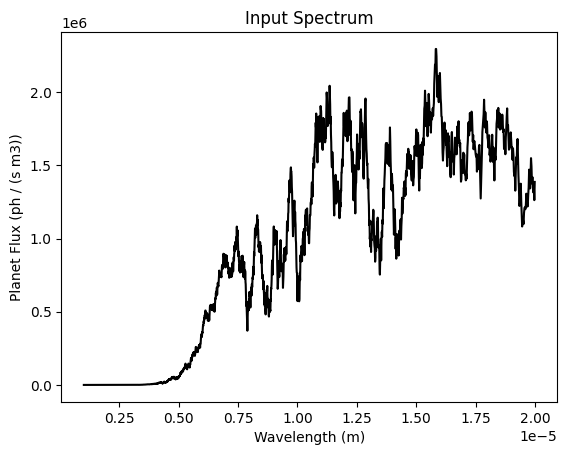

In [ ]:
#@title 1.A.4) Import the Spectrum Into LIFEsim
from lifesim.util.importer import SpectrumImporter
import matplotlib.pyplot as plt


# Import the spectrum, setting the planet properties
importer = SpectrumImporter()
importer.do_import(pathtotext=r'/content/1a_example_spectrum.txt',
                   x_string='micron',
                   y_string='ph m-2 s-1 micron-1',
                   radius_p_spectrum=None,
                   radius_p_target=planet_radius,
                   distance_s_spectrum=10.,
                   distance_s_target=star_distance,
                   integration_time=0)

flux_planet_spectrum = [importer.x_data, importer.y_data]

# Plot input spectrum
plt.plot(importer.x_data, importer.y_data, color='black')
plt.title('Input Spectrum')
plt.xlabel(f'Wavelength ({str(importer.x_data.unit)})')
plt.ylabel(f'Planet Flux ({str(importer.y_data.unit)})')
plt.show()


In [ ]:
#@title 1.A.5) Run the Simulation
from spectres import spectres


snr, flux, noise = instrument.get_spectrum(temp_s=star_temperature,
                                           radius_s=star_radius,
                                           distance_s=star_distance,
                                           lat_s=0.78, # In radians
                                           z=exozodi_level,
                                           angsep=planet_angular_separation,
                                           flux_planet_spectrum=flux_planet_spectrum, # In ph m-3 s-1 over m
                                           integration_time=integration_time,
                                           safe_mode=False)


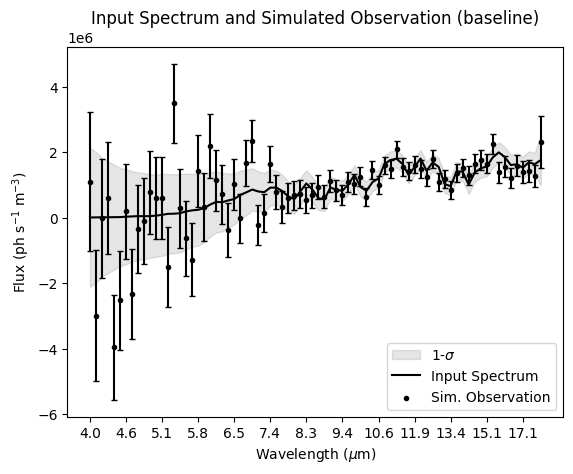

In [ ]:
#@title 1.A.6) Plot the Simulated Observation Results

# Rescale original spectrum to match amount of bins for plotting
flux_planet_spectrum_rescaled = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],
                                spec_wavs=flux_planet_spectrum[0].value,
                                spec_fluxes=flux_planet_spectrum[1].value,
                                edge_mode=True)

# Compute one draw from noise distribution
random_noise = np.random.normal(0,flux_planet_spectrum_rescaled/snr[1],
                                size = flux_planet_spectrum_rescaled.shape)

# Plot the input spectrum and measured spectrum
plt.fill_between(np.arange(len(flux)),
                 flux_planet_spectrum_rescaled-flux_planet_spectrum_rescaled/snr[1],
                 flux_planet_spectrum_rescaled+flux_planet_spectrum_rescaled/snr[1],
                 color='black', alpha=0.1, label='1-$\sigma$')

plt.plot(flux_planet_spectrum_rescaled, color='black', label='Input Spectrum')

plt.scatter(np.arange(len(flux)), flux_planet_spectrum_rescaled+random_noise,
            color='black', marker='.', label='Sim. Observation')

plt.errorbar(np.arange(len(flux)), flux_planet_spectrum_rescaled+random_noise,
             yerr=flux_planet_spectrum_rescaled/snr[1], color='black', capsize=2, ls='none')

plt.title(f'Input Spectrum and Simulated Observation ({scenario})')
plt.xlabel('Wavelength ($\mu$m)')
plt.xticks(ticks=np.arange(len(flux))[::6], labels=np.round(snr[0][::6]*1e6, 1))
plt.ylabel('Flux (ph s$^{-1}$ m$^{-3}$)')
plt.legend()
plt.show()


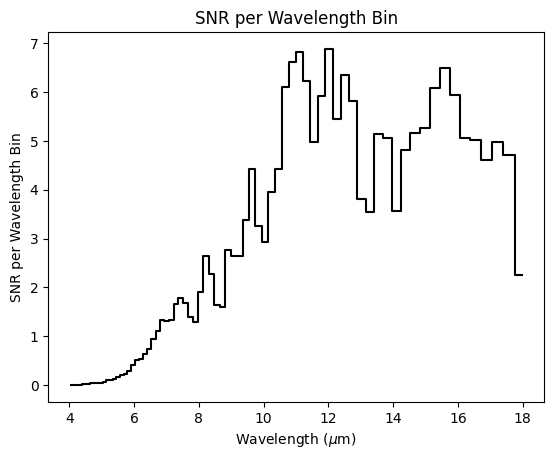

In [ ]:
#@title 1.A.7) Plot the SNR per Wavelength Bin
plt.step(snr[0]*1e6, snr[1], c='black')
plt.title('SNR per Wavelength Bin')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SNR per Wavelength Bin')
plt.show()


##1.B) Your Turn: What can LIFE detect?
Under what conditions (integration time, instrumental parameters) can LIFE detect an Earth atmosphere with 1000x O3 with statistical significance? In this example we use two PSG-generated spectra and calculate the statistical significance, with which we can differentiate specific features.

**Your task:** Play around with the observational/instrumental parameters to find out what is needed for statistically relevant detections.

Note: With the exception of step 0), this example is self-contained.

In [ ]:
#@title 1.B.1) Download and Save the Example Spectrum
import requests
import numpy as np


url = r'https://raw.githubusercontent.com/pahuber/LIFEsim_Tutorial/main/1b_psg_full_data.txt'
url_o3 = r'https://raw.githubusercontent.com/pahuber/LIFEsim_Tutorial/main/1b_psg_full_data_o3.txt'

response = requests.get(url)
response_o3 = requests.get(url_o3)

with open('/content/1b_psg_full_data.txt', 'w') as text_file:
  text_file.write(response.text)

with open('/content/1b_psg_full_data_o3.txt', 'w') as text_file:
  text_file.write(response_o3.text)


In [ ]:
#@title 1.B.2) Extract "Wavelength" and "Spectral Irradiance" columns from txt-File
import pandas as pd

# Read in the file as a pandas dataframe
dataframe = pd.read_csv('/content/1b_psg_full_data.txt', sep='  ', header=None,
                   names=['wavelength', 'spectral_irradiance', '_', '__'], comment='#')

dataframe_o3 = pd.read_csv('/content/1b_psg_full_data_o3.txt', sep='  ', header=None,
                   names=['wavelength', 'spectral_irradiance', '_', '__'], comment='#')

# Save the relevant columns as a new txt-file
dataframe.loc[:, ['wavelength', 'spectral_irradiance']].to_csv('/content/1b_psg_spectrum.txt', header=None, sep='\t', index=False)
dataframe_o3.loc[:, ['wavelength', 'spectral_irradiance']].to_csv('/content/1b_psg_spectrum_o3.txt', header=None, sep='\t', index=False)


In [ ]:
#@title 1.B.3) Set Your Simulation Variables
scenario = 'baseline' # Options: 'basline', 'pessimistic', 'optimistic'
spectral_resolution = 50  # Resolving power
minimum_wavelength = 4 # Minimum wavelength of the spectrometer in micron
maximum_wavelength = 18 # Maximum wavelength of the spectrometer in micron
integration_time = 1*24*60*60  # Overall integration time in s

planet_radius = 1  # Planet effective radius in Earth radii
planet_angular_separation = 0.1  # Planet angular separation from host star in arcsec
star_distance = 10  # Distance to the target system in pc
star_temperature = 5778  # Star effective temperature in K
star_radius = 1  # Star effective radius in Solar radii
exozodi_level = 3  # Exozodi level in zodis


In [ ]:
#@title 1.B.4) Set up LIFEsim Pipeline
import lifesim

# Create bus
bus = lifesim.Bus()

# Set the baseline scenario
bus.data.options.set_scenario(scenario)

# Set some options manually
bus.data.options.set_manual(spec_res=spectral_resolution)
bus.data.options.set_manual(wl_min=minimum_wavelength)
bus.data.options.set_manual(wl_max=maximum_wavelength)

# Create the instrument and add it to the bus
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)

# Create the transmission map and add it to the bus
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

# Create the noise sources and add them to the bus
exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)

local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)

star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# Connect all modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))


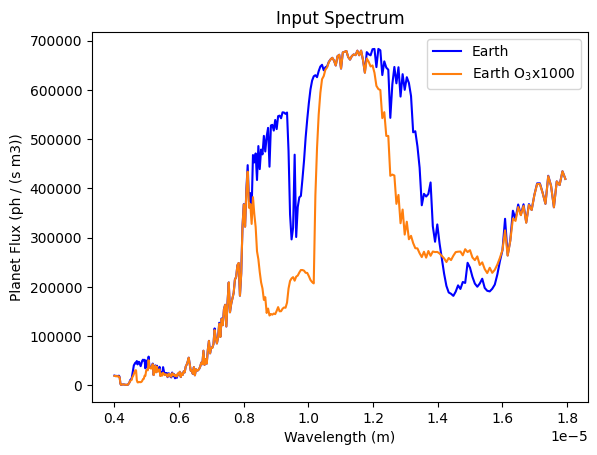

In [ ]:
#@title 1.B.5) Import the Spectra Into LIFEsim
from lifesim.util.importer import SpectrumImporter
import matplotlib.pyplot as plt


# Import the spectrum, setting the planet properties
importer = SpectrumImporter()
importer_o3 = SpectrumImporter()

importer.do_import(pathtotext=r'/content/1b_psg_spectrum.txt',
                   x_string='micron',
                   y_string='W m-2 micron-1',
                   radius_p_spectrum=None,
                   radius_p_target=planet_radius,
                   distance_s_spectrum=10.,
                   distance_s_target=star_distance,
                   integration_time=0)

importer_o3.do_import(pathtotext=r'/content/1b_psg_spectrum_o3.txt',
                      x_string='micron',
                      y_string='W m-2 micron-1',
                      radius_p_spectrum=None,
                      radius_p_target=planet_radius,
                      distance_s_spectrum=10.,
                      distance_s_target=star_distance,
                      integration_time=0)

flux_planet_spectrum = [importer.x_data, importer.y_data]
flux_planet_spectrum_o3 = [importer_o3.x_data, importer_o3.y_data]

# Plot input spectrum
plt.plot(importer.x_data, importer.y_data, label='Earth', color='blue')
plt.plot(importer_o3.x_data, importer_o3.y_data, label='Earth O$_3$x1000', color='tab:orange')
plt.title('Input Spectrum')
plt.xlabel(f'Wavelength ({str(importer.x_data.unit)})')
plt.ylabel(f'Planet Flux ({str(importer.y_data.unit)})')
plt.legend()
plt.show()


In [ ]:
#@title 1.B.6) Run the Simulation
from spectres import spectres


snr, flux, noise = instrument.get_spectrum(temp_s=star_temperature,
                                           radius_s=star_radius,
                                           distance_s=star_distance,
                                           lat_s=0.78, # In radians
                                           z=exozodi_level,
                                           angsep=planet_angular_separation,
                                           flux_planet_spectrum=flux_planet_spectrum, # In ph m-3 s-1 over m
                                           integration_time=integration_time,
                                           safe_mode=False)

snr_o3, flux_o3, noise_o3 = instrument.get_spectrum(temp_s=star_temperature,
                                                    radius_s=star_radius,
                                                    distance_s=star_distance,
                                                    lat_s=0.78, # In radians
                                                    z=exozodi_level,
                                                    angsep=planet_angular_separation,
                                                    flux_planet_spectrum=flux_planet_spectrum_o3, # In ph m-3 s-1 over m
                                                    integration_time=integration_time,
                                                    safe_mode=False)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



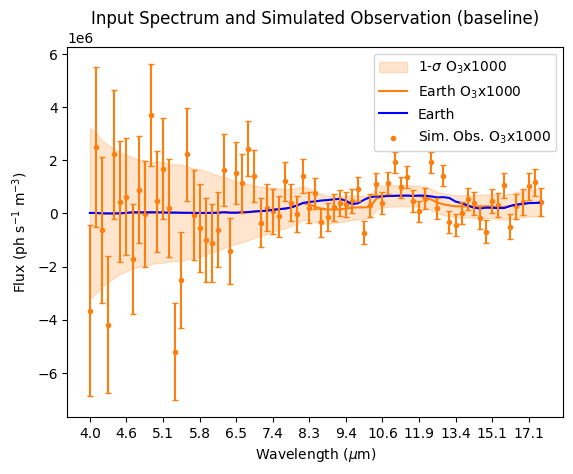

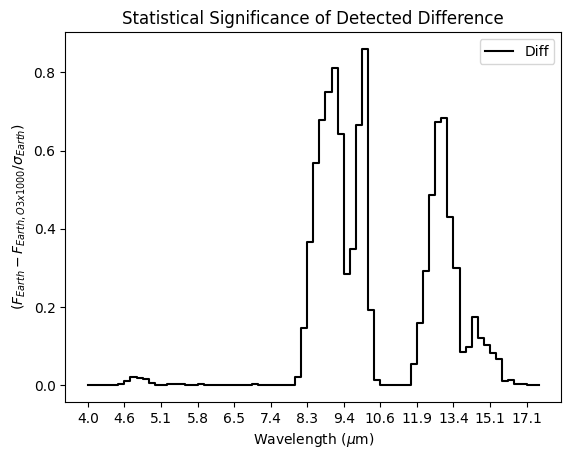

In [ ]:
#@title 1.B.7) Plot the Simulated Observation Results
import numpy as np

# Rescale original spectrum to match amount of bins for plotting
flux_planet_spectrum_rescaled = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],
                                spec_wavs=flux_planet_spectrum[0].value,
                                spec_fluxes=flux_planet_spectrum[1].value,
                                edge_mode=True)

flux_planet_spectrum_rescaled_o3 = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],
                                            spec_wavs=flux_planet_spectrum_o3[0].value,
                                            spec_fluxes=flux_planet_spectrum_o3[1].value,
                                            edge_mode=True)

# Compute one draw from noise distribution
random_noise = np.random.normal(0, flux_planet_spectrum_rescaled/snr[1],
                                size = flux_planet_spectrum_rescaled.shape)

random_noise_o3 = np.random.normal(0, flux_planet_spectrum_rescaled_o3/snr_o3[1],
                                   size = flux_planet_spectrum_rescaled_o3.shape)

# Plot the input spectra and the simulated observation results
plt.fill_between(np.arange(len(flux_o3)),
                 flux_planet_spectrum_rescaled_o3-flux_planet_spectrum_rescaled_o3/snr_o3[1],
                 flux_planet_spectrum_rescaled_o3+flux_planet_spectrum_rescaled_o3/snr_o3[1],
                 color='tab:orange', alpha=0.2, label='1-$\sigma$ O$_3$x1000')

plt.plot(flux_planet_spectrum_rescaled_o3, color='tab:orange', label='Earth O$_3$x1000')

plt.plot(flux_planet_spectrum_rescaled, color='blue', label='Earth')

plt.scatter(np.arange(len(flux_o3)), flux_planet_spectrum_rescaled_o3+random_noise_o3,
            color='tab:orange', marker='.', label='Sim. Obs. O$_3$x1000')
plt.errorbar(np.arange(len(flux_o3)), flux_planet_spectrum_rescaled_o3+random_noise_o3, yerr=flux_planet_spectrum_rescaled_o3/snr_o3[1],
            color='tab:orange', capsize=2, ls='none')

plt.title(f'Input Spectrum and Simulated Observation ({scenario})')
plt.xlabel('Wavelength ($\mu$m)')
plt.xticks(ticks=np.arange(len(flux))[::6], labels=np.round(snr[0][::6]*1e6, 1))
plt.ylabel('Flux (ph s$^{-1}$ m$^{-3}$)')
plt.legend()
plt.show()

# Plot the statistical significance
flux_difference_in_sigma = np.divide(abs(flux_planet_spectrum_rescaled - flux_planet_spectrum_rescaled_o3),
 (flux_planet_spectrum_rescaled/snr[1]))

plt.step(np.arange(len(flux_difference_in_sigma)), flux_difference_in_sigma, color='black', label='Diff')
plt.title('Statistical Significance of Detected Difference')
plt.ylabel('$(F_{Earth} - F_{Earth, O3x1000}/\sigma_{Earth})$')
plt.xlabel('Wavelength ($\mu$m)')
plt.xticks(ticks=np.arange(len(flux))[::6], labels=np.round(snr[0][::6]*1e6, 1))
plt.legend()
plt.show()


#2) Use Case: Yield Estimates
LIFEsim can be used to estimate exoplanet yields for the search phase of LIFE.

To assure reasonable computation times, a reduced exoplanet population catalog is used for these examples. An example of a full catalog can be foud [here](https://raw.githubusercontent.com/kammerje/P-pop/main/TestPlanetPopulation.txt).

##2.A) Demo: What is the Parameter Space of Exoplanets That LIFE can Detect?
In this example we use a P-Pop-generated exoplanet population catalog, plug it into LIFEsim and investigate the parameters of the detected and non-detected exoplanets.

Note: With the exception of step 0), this example is self-contained.

In [3]:
#@title 2.A.1) Download and Save the Example Catalog
import requests
import numpy as np


url = r'https://raw.githubusercontent.com/pahuber/LIFEsim_Tutorial/main/2a_example_catalog.txt'

response = requests.get(url)

with open('/content/2a_example_catalog.txt', 'w') as text_file:
  text_file.write(response.text)


In [4]:
#@title 2.A.2) Set Your Simulation Variables
scenario = 'baseline' # Options: 'basline', 'pessimistic', 'optimistic'
spectral_resolution = 50  # Resolving power
minimum_wavelength = 4 # Minimum wavelength of the spectrometer in micron
maximum_wavelength = 18 # Maximum wavelength of the spectrometer in micron


In [5]:
#@title 2.A.3) Set up LIFEsim Pipeline and Import Catalog
#import lifesim

# Create bus
bus = lifesim.Bus()

# Set the baseline scenario
bus.data.options.set_scenario(scenario)

# Import the catalog
bus.data.catalog_from_ppop(input_path='/content/2a_example_catalog.txt')
bus.data.catalog_remove_distance(stype='M', mode='larger', dist=10.)  # remove M stars > 10pc to
bus.data.catalog_remove_distance(stype='F', mode='larger', dist=10.)  # remove F stars > 10pc to
bus.data.catalog_remove_distance(stype='G', mode='larger', dist=10.)  # remove G stars > 10pc to
bus.data.catalog_remove_distance(stype='K', mode='larger', dist=10.)  # remove K stars > 10pc to
bus.data.catalog_remove_distance(stype='A', mode='larger', dist=10.)  # remove A stars > 10pc to

# Set some options manually
bus.data.options.set_manual(spec_res=spectral_resolution)
bus.data.options.set_manual(wl_min=minimum_wavelength)
bus.data.options.set_manual(wl_max=maximum_wavelength)
bus.data.options.set_manual(output_path='/content/')
bus.data.options.set_manual(output_filename='2a_results')

# Create the instrument and add it to the bus
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)

# Create the transmission map and add it to the bus
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

# Create the noise sources and add them to the bus
exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)

local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)

star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# Connect all modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))


Processed line 27492 of 27492


In [6]:
#@title 2.A.4) Create the Optimizer
opt = lifesim.Optimizer(name='opt')
bus.add_module(opt)
ahgs = lifesim.AhgsModule(name='ahgs')
bus.add_module(ahgs)

bus.connect(('transm', 'opt'))
bus.connect(('inst', 'opt'))
bus.connect(('opt', 'ahgs'))


In [7]:
#@title 2.A.5) Run the Simulation and Save the Results
instrument.get_snr()
opt.ahgs()
bus.save()

100%|██████████| 215/215 [02:54<00:00,  1.23it/s]


Number of planets detected by stellar type:
A: 0.0  F: 0.6  G: 0.8  K: 7.0  M: 54.2  -  (2.0 / 2.0) yrs observed
Saving database and config files...
Catalog saved
[Done]


In [ ]:
#@title 2.A.6) (In case you Want to Read From a Previous Run)
bus_read = lifesim.Bus()
bus_read.build_from_config('/content/2a_results.yaml')
bus_read.data.import_catalog(input_path='/content/2a_results_catalog.hdf5')

In [8]:
#@title 2.A.7) Have a Look at the Results
dataframe_yield = bus.data.catalog

# Have a look at the data
print(dataframe_yield.head())
print(dataframe_yield.columns)

   radius_p      p_orb   mass_p  ecc_p    inc_p  large_omega_p  small_omega_p  \
0   0.62452    5.72920  0.27646    0.0  2.30241        2.13434        1.04750   
1   1.52304  176.47964  1.36537    0.0  2.30241        3.30480        4.12457   
2   1.03903   50.88983  1.00030    0.0  2.26582        5.82014        5.69733   
3   0.62578  407.37069  0.11332    0.0  2.26582        4.03566        0.14723   
4   1.83578    7.99053  2.54385    0.0  1.44389        4.69478        2.66415   

   theta_p  albedo_bond  albedo_geom_vis  ...     hz_in    hz_out  hz_center  \
0  2.38388      0.61036          0.30455  ...  0.299106  0.749473   0.524289   
1  1.19495      0.28693          0.29690  ...  0.299106  0.749473   0.524289   
2  1.26921      0.28034          0.42647  ...  1.205747  2.749949   1.977848   
3  6.01076      0.26387          0.49819  ...  1.205747  2.749949   1.977848   
4  3.34550      0.52837          0.07342  ...  0.148359  0.384337   0.266348   

   habitable     snr_1h   baseli

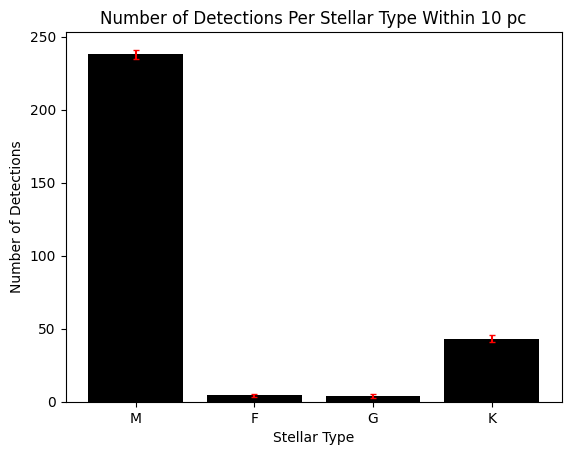

In [9]:
#@title 2.A.8) Plot Number of Detections per Stellar Type
import matplotlib.pyplot as plt


# Plot detections per stellar type
stellar_types = ['M', 'F', 'G', 'K']
number_of_universes = 5

detections_dict = {}

for index, stellar_type in enumerate(stellar_types):
  for number_of_universe in np.arange(number_of_universes):
    try:
      detections_dict[f'total_detections_{stellar_type}'].append(len(dataframe_yield[(dataframe_yield['nuniverse'] == number_of_universe) & (dataframe_yield['detected'] == True) & (dataframe_yield['stype'] == stellar_type)]))
    except KeyError:
         detections_dict[f'total_detections_{stellar_type}'] = []
  detections_dict[f'mean_detections_{stellar_type}']=np.mean(detections_dict[f'total_detections_{stellar_type}'])
  detections_dict[f'std_detections_{stellar_type}']=np.std(detections_dict[f'total_detections_{stellar_type}'])

  plt.bar(index, detections_dict[f'mean_detections_{stellar_type}'], color='black')
  plt.errorbar(index, detections_dict[f'mean_detections_{stellar_type}'],
               yerr=np.sqrt(detections_dict[f'std_detections_{stellar_type}']),
               color='red', capsize=2)

plt.title('Number of Detections Per Stellar Type Within 10 pc')
plt.ylabel('Number of Detections')
plt.xlabel('Stellar Type')
plt.xticks([0, 1, 2, 3], labels=stellar_types)
plt.show()

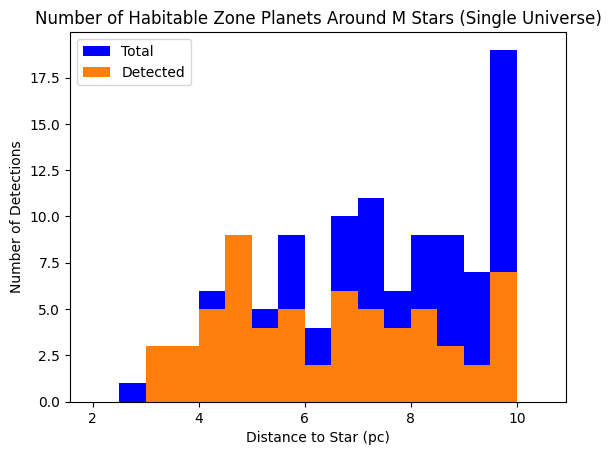

In [10]:
#@title 2.A.9) Plot Number of Detected Habitable Zone Planets Around M Stars

# Get total and detected planets
dataframe_detected_habitable_m_star = dataframe_yield[(dataframe_yield['nuniverse'] == 0) & (dataframe_yield['detected'] == True) & (dataframe_yield['stype'] == 'M') & (dataframe_yield['habitable'] == True)]
dataframe_total_habitable_m_star = dataframe_yield[(dataframe_yield['nuniverse'] == 0) & (dataframe_yield['stype'] == 'M') & (dataframe_yield['habitable'] == True)]
bins = np.arange(2, 11, 0.5)

# Plot histogram
plt.hist(dataframe_total_habitable_m_star['distance_s'], color='blue', bins=bins, label='Total')
plt.hist(dataframe_detected_habitable_m_star['distance_s'], color='tab:orange', bins=bins, label='Detected')
plt.title('Number of Habitable Zone Planets Around M Stars (Single Universe)')
plt.xlabel('Distance to Star (pc)')
plt.ylabel('Number of Detections')
plt.legend()
plt.show()


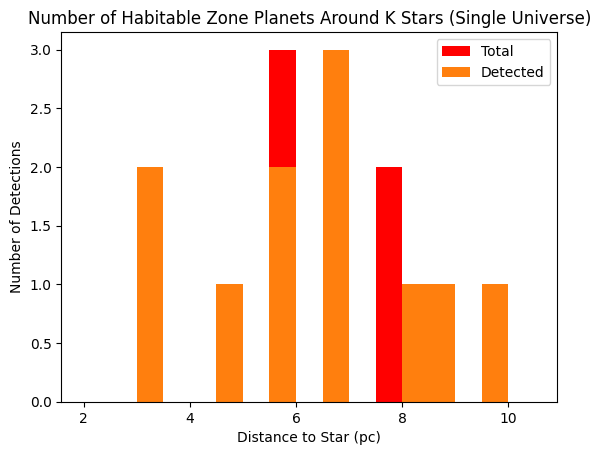

In [12]:
#Plot Number of Detected Habitable Zone Planets Around K Stars

# Get total and detected planets
dataframe_detected_habitable_m_star = dataframe_yield[(dataframe_yield['nuniverse'] == 0) & (dataframe_yield['detected'] == True) & (dataframe_yield['stype'] == 'K') & (dataframe_yield['habitable'] == True)]
dataframe_total_habitable_m_star = dataframe_yield[(dataframe_yield['nuniverse'] == 0) & (dataframe_yield['stype'] == 'K') & (dataframe_yield['habitable'] == True)]
bins = np.arange(2, 11, 0.5)

# Plot histogram
plt.hist(dataframe_total_habitable_m_star['distance_s'], color='red', bins=bins, label='Total')
plt.hist(dataframe_detected_habitable_m_star['distance_s'], color='tab:orange', bins=bins, label='Detected')
plt.title('Number of Habitable Zone Planets Around K Stars (Single Universe)')
plt.xlabel('Distance to Star (pc)')
plt.ylabel('Number of Detections')
plt.legend()
plt.show()


##2.B) Your Turn: How Many Favorite Exoplanets?
In this example we use a P-Pop-generated exoplanet population catalog, plug it into LIFEsim and investigate the parameters of the detected and non-detected exoplanets.

**Your task:** Play around with the yield data and try to find out how many exoplanets of your favorite type can be detected with LIFE within 10 pc in 20 days, given the baseline scenario.

Note: With the exception of step 0), this example is self-contained.

In [ ]:
#@title 2.B.1) Download and Save the Example Catalog (You can skip this if you have done it above)
import requests
import numpy as np


url = r'https://raw.githubusercontent.com/pahuber/LIFEsim_Tutorial/main/2a_example_catalog.txt'

response = requests.get(url)

with open('/content/2a_example_catalog.txt', 'w') as text_file:
  text_file.write(response.text)


In [ ]:
#@title 2.B.2) Set Your Simulation Variables
scenario = 'baseline' # Options: 'basline', 'pessimistic', 'optimistic'
spectral_resolution = 50  # Resolving power
minimum_wavelength = 4 # Minimum wavelength of the spectrometer in micron
maximum_wavelength = 18 # Maximum wavelength of the spectrometer in micron


In [ ]:
#@title 2.B.3) Set up LIFEsim Pipeline and Import Catalog
import lifesim

# Create bus
bus = lifesim.Bus()

# Set the baseline scenario
bus.data.options.set_scenario(scenario)

# Import the catalog
bus.data.catalog_from_ppop(input_path='/content/2a_example_catalog.txt')
bus.data.catalog_remove_distance(stype='M', mode='larger', dist=10.)  # remove M stars > 10pc to
bus.data.catalog_remove_distance(stype='F', mode='larger', dist=10.)  # remove F stars > 10pc to
bus.data.catalog_remove_distance(stype='G', mode='larger', dist=10.)  # remove G stars > 10pc to
bus.data.catalog_remove_distance(stype='K', mode='larger', dist=10.)  # remove K stars > 10pc to
bus.data.catalog_remove_distance(stype='A', mode='larger', dist=10.)  # remove A stars > 10pc to

# Set some options manually
bus.data.options.set_manual(spec_res=spectral_resolution)
bus.data.options.set_manual(wl_min=minimum_wavelength)
bus.data.options.set_manual(wl_max=maximum_wavelength)
bus.data.options.set_manual(output_path='/content/')
bus.data.options.set_manual(output_filename='2a_results')

# Create the instrument and add it to the bus
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)

# Create the transmission map and add it to the bus
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

# Create the noise sources and add them to the bus
exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)

local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)

star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# Connect all modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))


In [ ]:
#@title 2.B.4) Create the Optimizer
opt = lifesim.Optimizer(name='opt')
bus.add_module(opt)
ahgs = lifesim.AhgsModule(name='ahgs')
bus.add_module(ahgs)

bus.connect(('transm', 'opt'))
bus.connect(('inst', 'opt'))
bus.connect(('opt', 'ahgs'))


In [ ]:
#@title 2.B.5) Run the Simulation and Save the Results
instrument.get_snr()
opt.ahgs()
bus.save()


In [ ]:
#@title 2.B.6) Have a Look at the Results
dataframe_yield = bus.data.catalog

# Have a look at the data
print(dataframe_yield.head())
print(dataframe_yield.columns)


   radius_p      p_orb   mass_p  ecc_p    inc_p  large_omega_p  small_omega_p  \
0   0.62452    5.72920  0.27646    0.0  2.30241        2.13434        1.04750   
1   1.52304  176.47964  1.36537    0.0  2.30241        3.30480        4.12457   
2   1.03903   50.88983  1.00030    0.0  2.26582        5.82014        5.69733   
3   0.62578  407.37069  0.11332    0.0  2.26582        4.03566        0.14723   
4   1.83578    7.99053  2.54385    0.0  1.44389        4.69478        2.66415   

   theta_p  albedo_bond  albedo_geom_vis  ...     name_s       lon       lat  \
0  2.38388      0.61036          0.30455  ...    *61CygA  5.881006  0.905810   
1  1.19495      0.28693          0.29690  ...    *61CygA  5.881006  0.905810   
2  1.26921      0.28034          0.42647  ...    *gamLep  1.480843 -0.799678   
3  6.01076      0.26387          0.49819  ...    *gamLep  1.480843 -0.799678   
4  3.34550      0.52837          0.07342  ...  BD+442051  2.592930  0.599095   

       s_in     s_out     l_sun 

In [ ]:
#@title 2.B.7) Count how Many Exoplanets of Type X can be Detected?
dataframe_total_habitable_earth_radius = dataframe_yield[(dataframe_yield['radius_p'] >= 0.8) & (dataframe_yield['radius_p'] >= 1.2) & (dataframe_yield['habitable'] == True)]
print(len(dataframe_total_habitable_earth_radius)/5)
